### wide-deep model for regression problem

In [105]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import tensorflow as tf

from tensorflow import keras

print('TF 版本号:', tf.__version__)

TF 版本号: 2.5.0


In [106]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
# print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

(20640, 8)
(20640,)


In [107]:
from sklearn.model_selection import train_test_split

x_train_all, x_test, y_train_all, y_test = train_test_split(
    housing.data, housing.target, random_state=7)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all, y_train_all, random_state=11)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)


(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [108]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

#### 方法一：函数式(功能)API

`models.Sequential` 不适用于 wide-deep 模型，因为该模型左右两侧的神经元层数不一样。编写代码时需要对deep模型增加两层hidden层，wide模型无需任何操作。

In [109]:
# input = keras.layers.Input(shape=x_train.shape[1:])
# hidden1 = keras.layers.Dense(30, activation='relu')(input)
# hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
# # 复合函数: f(x) = h(g(x))
#
# concat = keras.layers.concatenate([input, hidden2])
# output = keras.layers.Dense(1)(concat)
#
# model = keras.models.Model(inputs = [input],
#                            outputs = [output])

#### 函数式API + 多输入 + 多输出

In [110]:
# wide模型。表示wide层取5个特征。
input_wide = tf.keras.layers.Input(shape=[5])

# deep模型
input_deep = tf.keras.layers.Input(shape=[6])
hidden1 = tf.keras.layers.Dense(30, activation='relu')(input_deep)
hidden2 = tf.keras.layers.Dense(30, activation='relu')(hidden1)
# 拼接 wide 和 deep
concat = tf.keras.layers.concatenate([input_wide, hidden2])
output = tf.keras.layers.Dense(1)(concat)

output2 = tf.keras.layers.Dense(1)(hidden2)

model = tf.keras.models.Model(inputs = [input_wide, input_deep],
                              outputs = [output, output2])

x_train_scaled_wide = x_train_scaled[:, :5]
x_train_scaled_deep = x_train_scaled[:, 2:]
x_valid_scaled_wide = x_valid_scaled[:, :5]
x_valid_scaled_deep = x_valid_scaled[:, 2:]
x_test_scaled_wide = x_test_scaled[:, :5]
x_test_scaled_deep = x_test_scaled[:, 2:]

#### 方法二：子类API

In [111]:
# class WideDeepModel(keras.models.Model):
#     def __init__(self):
#         super(WideDeepModel, self).__init__()
#         """定义模型的层次"""
#         self.hidden1_layer = keras.layers.Dense(30, activation='relu')
#         self.hidden2_layer = keras.layers.Dense(30, activation='relu')
#         self.output_layer = keras.layers.Dense(1)
#
#     def call(self, input):
#         """完成模型的正向计算"""
#         hidden1 = self.hidden1_layer(input)
#         hidden2 = self.hidden2_layer(hidden1)
#         concat = keras.layers.concatenate([input, hidden2])
#         output = self.output_layer(concat)
#         return output
# # model = WideDeepModel()
# model = keras.models.Sequential([
#     WideDeepModel(),
# ])
#
# model.build(input_shape=(None, 8))

In [112]:
# model = keras.models.Sequential([
#     keras.layers.Dense(30, activation='relu',
#                        input_shape=x_train.shape[1:]),
#     keras.layers.Dense(1),
# ])

model.summary()
model.compile(loss="mean_squared_error", optimizer="adam")
callbacks = [keras.callbacks.EarlyStopping(
    patience=5, min_delta=1e-2)]

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_26 (Dense)                (None, 30)           210         input_11[0][0]                   
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_27 (Dense)                (None, 30)           930         dense_26[0][0]                   
____________________________________________________________________________________________

In [113]:
# history = model.fit(x_train_scaled, y_train,
#                     validation_data=(x_valid_scaled, y_valid),
#                     epochs=100,
#                     callbacks=callbacks)

history = model.fit([x_train_scaled_wide, x_train_scaled_deep], [y_train, y_train],
                    validation_data = (
                        [x_valid_scaled_wide, x_valid_scaled_deep], [y_valid, y_valid]),
                    epochs = 100,
                    callbacks = callbacks)


Epoch 1/100
 15/363 [>.............................] - ETA: 2s - loss: 9.6645 - dense_28_loss: 5.0929 - dense_29_loss: 4.5715   

2021-08-06 12:10:21.473005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


358/363 [============================>.] - ETA: 0s - loss: 3.1177 - dense_28_loss: 1.5294 - dense_29_loss: 1.5883

2021-08-06 12:10:24.400641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


363/363 [==============================] - 4s 9ms/step - loss: 3.0919 - dense_28_loss: 1.5168 - dense_29_loss: 1.5751 - val_loss: 1.4059 - val_dense_28_loss: 0.6385 - val_dense_29_loss: 0.7674
Epoch 2/100
363/363 [==============================] - 3s 9ms/step - loss: 1.1516 - dense_28_loss: 0.5288 - dense_29_loss: 0.6229 - val_loss: 1.0946 - val_dense_28_loss: 0.4853 - val_dense_29_loss: 0.6092

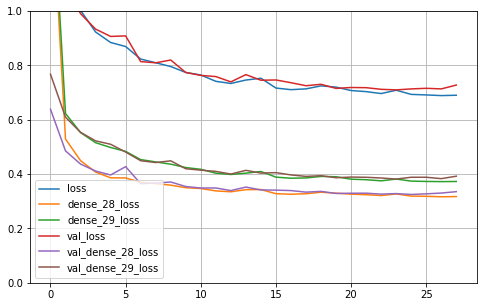

In [114]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

In [115]:
model.evaluate([x_test_scaled_wide, x_test_scaled_deep], [y_test, y_test])

162/162 [==============================] - 1s 5ms/step - loss: 0.7539 - dense_28_loss: 0.3407 - dense_29_loss: 0.4133

[0.7539341449737549, 0.3406813144683838, 0.4132525324821472]